# Classification of emotions

## Importing the libraries

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import save_model
from IPython.display import display
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Loading the images

In [2]:
path = '../material/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

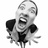

In [3]:
tf.keras.preprocessing.image.load_img('./fer2013/train/Angry/1003.jpg')

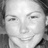

In [4]:
image = tf.keras.preprocessing.image.load_img('./fer2013/train/Happy/1.jpg')
image

### Train and test set

In [5]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('./fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [6]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [7]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [8]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

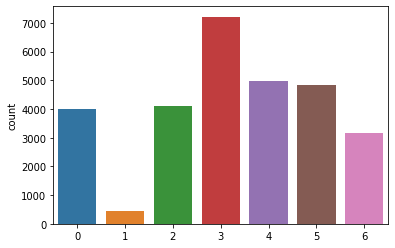

In [9]:
sns.countplot(x = train_dataset.classes);

In [10]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('./fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [ ]:
2*2*2*32

256

In [11]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 70

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/70
1795/1795 [==============================] - 38s 20ms/step - loss: 2.0256 - accuracy: 0.2246
Epoch 2/70
1795/1795 [==============================] - 37s 21ms/step - loss: 1.5614 - accuracy: 0.3895
Epoch 3/70
1795/1795 [==============================] - 37s 20ms/step - loss: 1.4009 - accuracy: 0.4619
Epoch 4/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.3134 - accuracy: 0.5061
Epoch 5/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.2743 - accuracy: 0.5183
Epoch 6/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.2236 - accuracy: 0.5400
Epoch 7/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1825 - accuracy: 0.5598
Epoch 8/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1613 - accuracy: 0.5653
Epoch 9/70
1795/1795 [==============================] - 36s 20ms/step - loss: 1.1426 - accuracy: 0.5772
Epoch 10/70
1795/1795 [==============================] - 36s 20m

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
    json_file.write(model_json)

In [ ]:
network_saved = save_model(network, './weights_emotions.hdf5')

In [13]:
with open('../material/Weights/network_emotions.json', 'r') as json_file:
    json_saved_model = json_file.read()

In [14]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('../material/Weights/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)       

## Evaluating the neural network

In [16]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 12s 3ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [17]:
predictions = network_loaded.predict(test_dataset)

In [18]:
predictions = np.argmax(predictions, axis = 1)

In [19]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [20]:
accuracy_score(test_dataset.classes, predictions)

0.5778768459180831

In [21]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

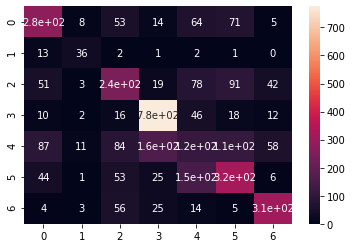

In [22]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [23]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



## Classifying one single image

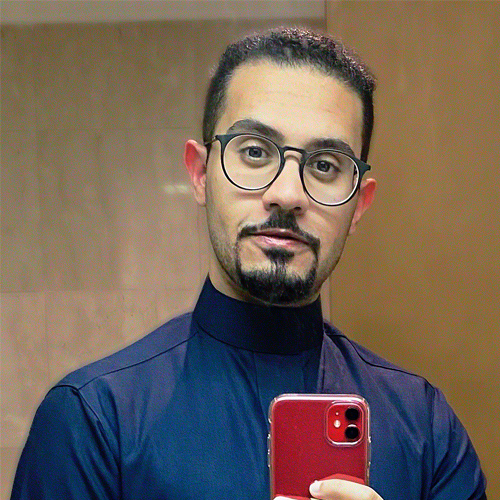

In [34]:
image = cv2.imread('./hello.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

In [35]:
image.shape

(500, 500, 3)

In [36]:
face_detector = cv2.CascadeClassifier('../material/Cascades/haarcascade_frontalface_default.xml')

In [37]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

In [38]:
faces

array([[181,  73, 215, 215]], dtype=int32)

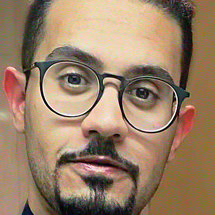

In [57]:
# mazen = image[73:73 + 215, 181:181 + 215]
mazen = image[faces[0][1]:faces[0][1] + faces[0][2], faces[0][0]:faces[0][0] + faces[0][2]]
display(Image.fromarray(mazen))

In [41]:
mazen.shape

(215, 215, 3)

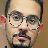

In [43]:
mazen = cv2.resize(mazen, (48, 48))
display(Image.fromarray(mazen))

In [44]:
mazen.shape

(48, 48, 3)

In [45]:
mazen

array([[[121, 112,  80],
        [120, 112,  87],
        [128, 107,  89],
        ...,
        [148, 113,  68],
        [143, 112,  77],
        [144, 112,  74]],

       [[131, 108,  70],
        [135, 107,  83],
        [125, 112,  81],
        ...,
        [158, 105,  72],
        [154, 110,  67],
        [147, 109,  84]],

       [[130, 107,  79],
        [127, 114,  69],
        [122, 116,  78],
        ...,
        [148, 111,  76],
        [158, 105,  83],
        [142, 118,  73]],

       ...,

       [[181, 141, 118],
        [168, 149, 120],
        [174, 143, 122],
        ...,
        [123, 116,  59],
        [139, 111,  56],
        [143, 106,  68]],

       [[174, 146, 121],
        [186, 139, 135],
        [176, 144, 120],
        ...,
        [139, 109,  43],
        [153,  99,  64],
        [131, 112,  55]],

       [[161, 151, 106],
        [174, 144, 129],
        [173, 145, 115],
        ...,
        [136, 103,  68],
        [130, 111,  63],
        [133, 111,  55]]

In [46]:
mazen = mazen / 255
mazen

array([[[0.4745098 , 0.43921569, 0.31372549],
        [0.47058824, 0.43921569, 0.34117647],
        [0.50196078, 0.41960784, 0.34901961],
        ...,
        [0.58039216, 0.44313725, 0.26666667],
        [0.56078431, 0.43921569, 0.30196078],
        [0.56470588, 0.43921569, 0.29019608]],

       [[0.51372549, 0.42352941, 0.2745098 ],
        [0.52941176, 0.41960784, 0.3254902 ],
        [0.49019608, 0.43921569, 0.31764706],
        ...,
        [0.61960784, 0.41176471, 0.28235294],
        [0.60392157, 0.43137255, 0.2627451 ],
        [0.57647059, 0.42745098, 0.32941176]],

       [[0.50980392, 0.41960784, 0.30980392],
        [0.49803922, 0.44705882, 0.27058824],
        [0.47843137, 0.45490196, 0.30588235],
        ...,
        [0.58039216, 0.43529412, 0.29803922],
        [0.61960784, 0.41176471, 0.3254902 ],
        [0.55686275, 0.4627451 , 0.28627451]],

       ...,

       [[0.70980392, 0.55294118, 0.4627451 ],
        [0.65882353, 0.58431373, 0.47058824],
        [0.68235294, 0

In [48]:
mazen = np.expand_dims(mazen, axis = 0)
mazen.shape

(1, 48, 48, 3)

In [49]:
probs = network_loaded.predict(mazen)
probs

array([[6.8761851e-03, 1.7545627e-04, 4.2407814e-02, 5.1639283e-01,
        3.7950227e-01, 1.8206120e-02, 3.6439378e-02]], dtype=float32)

In [50]:
result = np.argmax(probs)
result

3

In [51]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## Classifying multiple images

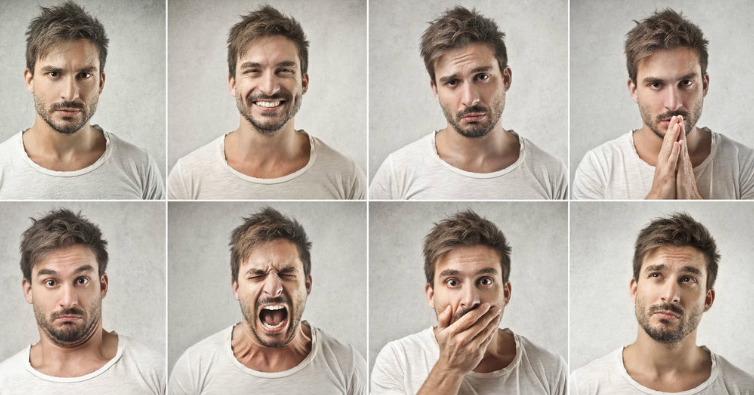

In [59]:
image = cv2.imread('../material/Images/faces_emotions.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

In [60]:
faces = face_detector.detectMultiScale(image)
faces

array([[226,  36,  87,  87],
       [625,  50,  89,  89],
       [ 21,  40,  94,  94],
       [419,  43,  98,  98],
       [228, 242,  86,  86],
       [421, 243,  95,  95],
       [ 19, 243,  97,  97],
       [628, 242,  88,  88]], dtype=int32)

In [61]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [62]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

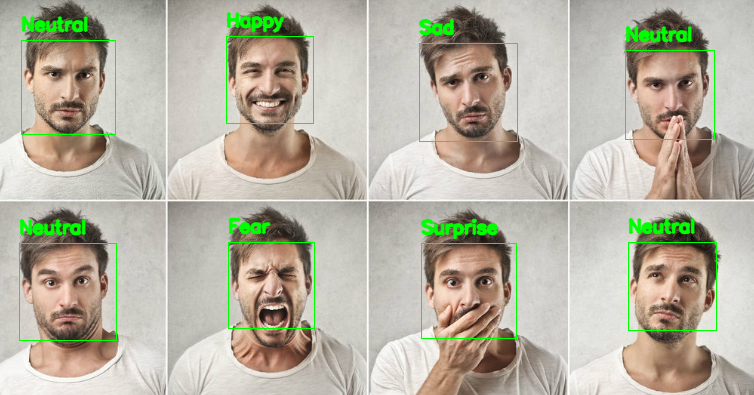

In [63]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    current_face = image[y:y + h, x:x + w]
    #cv2_imshow(current_face)
    current_face = cv2.resize(current_face, (48, 48))
    #cv2_imshow(current_face)
    current_face = current_face / 255
    current_face = np.expand_dims(current_face, axis = 0)
    #print(current_face.shape)
    prediction = network_loaded.predict(current_face)
    #print(prediction)
    cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

display(Image.fromarray(image))

## Classifying emotions in videos

In [64]:
cap = cv2.VideoCapture('../material/Videos/emotion_test01.mp4')
connected, video = cap.read()
print(connected, video.shape)

True (360, 640, 3)


In [67]:
# fourcc.org
save_path = './emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [68]:
while (cv2.waitKey(1) < 0):
    connected, frame = cap.read()
    if not connected:
        break
    faces = face_detector.detectMultiScale(frame, scaleFactor=1.2, minNeighbors=5, minSize=(30,30))
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            current_face = frame[y:y + h, x:x + w]
            current_face = cv2.resize(current_face, (48, 48))
            current_face = current_face / 255
            current_face = np.expand_dims(current_face, axis = 0)
            prediction = network_loaded.predict(current_face)

            if prediction is not None:
                result = np.argmax(prediction)
                cv2.putText(frame, emotions[result], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

        output_video.write(frame)
print('End')
output_video.release()
cv2.destroyAllWindows()

End
